### Importation des bibliothèques

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


import xgboost as xgb
from prophet import Prophet

### Chargement des données

### Installation le connecteur 

In [7]:
!pip install psycopg2-binary


In [8]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine


In [9]:

host = "localhost"
port = "5432"
database = "DW_SCF"
user = "postgres"
password = "ishrak123"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")


In [10]:
df_warehouse = pd.read_sql('SELECT * FROM "public"."Dim_Warehouse"', engine)
df_warehouse.head()


,Ware_ID_PK,warehouseid,warehousename,location,capacity,Latitude,Longitude,espace_refrigeree
0,1,1,Entrepôt Central de Tunis,"Tunis, Tunisie",99111,33.843940,9.400138,oui
1,2,2,Installation de Stockage de Sousse,"Sousse, Tunisie",40243,35.828827,10.640526,non
2,3,3,Centre de Distribution de Monastir,"Monastir, Tunisie",98970,35.770760,10.828052,oui
3,4,4,Hub de Stockage de Gabès,"Gabes, Tunisie",50732,33.887810,10.100440,oui
4,5,5,Dépôt Nord de Bizerte,"Bizerte, Tunisie",67535,37.272090,9.870856,oui


In [11]:
df_produit = pd.read_sql('SELECT * FROM "public"."Dim Produit"', engine)
df_produit.head()

,id_produit_PK,Product_ID,Product_Name,Brand,Price,Size_Volume,Average_Rating,Temperature,Stocker_sans_lumiere,Categorie
0,1,PR-2846178,Hair Density Boosting Scalp Serum for Thinning...,AAVRANI,30.0,Size: .88 oz / 26 ml - 2 month supply,4.5242,4-8°C (Réfrigéré),Oui,Cheveux
1,2,PR-2760346,Hair Density Boosting Scalp Serum for Thinning...,AAVRANI,48.0,Size: 2 oz / 60 ml - 4 Month Supply,4.5242,4-8°C (Réfrigéré),Oui,Cheveux
2,3,PR-2761724,"Deep Conditioning Hair Mask for Dry, Damaged Hair",AAVRANI,39.0,Size: 8.4 oz,4.5659,15-25°C (Température ambiante),Non,Cheveux
3,4,PR-2760353,Mini Strengthening Hair Oil & Growth Serum Gif...,AAVRANI,35.0,,4.6772,4-8°C (Réfrigéré),Oui,Cheveux
4,5,PR-2760361,Hair and Scalp Recovery Pre-Wash Oil for Stren...,AAVRANI,35.0,Size: 1.7 oz,4.7087,15-25°C (Température ambiante),Oui,Cheveux


In [12]:
df_date = pd.read_sql('SELECT * FROM "public"."Dim_Date"', engine)
df_date.head()

,id_Date_pk,fulldate
0,1,2022-01-01 00:00:00
1,2,2022-01-01 01:00:00
2,3,2022-01-01 02:00:00
3,4,2022-01-01 03:00:00
4,5,2022-01-01 04:00:00


In [13]:
df_fact = pd.read_sql('SELECT * FROM "public"."Fact_Inventory"', engine)
df_fact.head()

,id_produit_FK,Ware_ID_FK,id_Date_Stockage_FK,id_Date_Sortie_FK,Stock_Initial,Stock_Entrant,Stock_Sortant,Stock_Final,Produits_Endommages,Retour_de_commande
0,1,5,22129,22585,900,216,63,1053,35,33
1,2,11,26473,26881,302,302,273,331,28,33
2,3,1,23089,23521,271,275,546,0,11,58
3,4,18,18577,19033,635,173,224,584,8,80
4,5,24,27769,28105,470,124,434,160,34,13


In [14]:

df_merged = df_fact.merge(df_produit, left_on='id_produit_FK', right_on='id_produit_PK', how='left')


df_merged = df_merged.merge(df_warehouse, left_on='Ware_ID_FK', right_on='Ware_ID_PK', how='left')


df_merged = df_merged.merge(df_date, left_on='id_Date_Stockage_FK', right_on='id_Date_pk', how='left')
df_merged = df_merged.merge(df_date, left_on='id_Date_Sortie_FK', right_on='id_Date_pk', how='left')

df_merged.head()



,id_produit_FK,Ware_ID_FK,id_Date_Stockage_FK,id_Date_Sortie_FK,Stock_Initial,Stock_Entrant,Stock_Sortant,Stock_Final,Produits_Endommages,Retour_de_commande,...,warehousename,location,capacity,Latitude,Longitude,espace_refrigeree,id_Date_pk_x,fulldate_x,id_Date_pk_y,fulldate_y
0,1,5,22129,22585,900,216,63,1053,35,33,...,Dépôt Nord de Bizerte,"Bizerte, Tunisie",67535,37.27209,9.870856,oui,22129,2024-07-11,22585,2024-07-30
1,2,11,26473,26881,302,302,273,331,28,33,...,Centre de Stockage de Tozeur,"Tozeur, Tunisie",68235,33.92390,8.137064,oui,26473,2025-01-08,26881,2025-01-25
2,3,1,23089,23521,271,275,546,0,11,58,...,Entrepôt Central de Tunis,"Tunis, Tunisie",99111,33.84394,9.400138,oui,23089,2024-08-20,23521,2024-09-07
3,4,18,18577,19033,635,173,224,584,8,80,...,Dépôt de Siliana,"Siliana, Tunisie",67126,35.97153,9.357713,oui,18577,2024-02-14,19033,2024-03-04
4,5,24,27769,28105,470,124,434,160,34,13,...,Stockage de Sidi Bouzid,"Sidi Bouzid, Tunisie",54039,34.88118,9.526360,oui,27769,2025-03-03,28105,2025-03-17


In [15]:

df_merged_cleaned = df_merged.drop(columns=[col for col in df_merged.columns if any(x in col.lower() for x in ['id', 'pk', 'fk'])])



In [16]:
df_merged_cleaned.head()


,Stock_Initial,Stock_Entrant,Stock_Sortant,Stock_Final,Produits_Endommages,Retour_de_commande,Product_Name,Brand,Price,Size_Volume,...,Stocker_sans_lumiere,Categorie,warehousename,location,capacity,Latitude,Longitude,espace_refrigeree,fulldate_x,fulldate_y
0,900,216,63,1053,35,33,Hair Density Boosting Scalp Serum for Thinning...,AAVRANI,30.0,Size: .88 oz / 26 ml - 2 month supply,...,Oui,Cheveux,Dépôt Nord de Bizerte,"Bizerte, Tunisie",67535,37.27209,9.870856,oui,2024-07-11,2024-07-30
1,302,302,273,331,28,33,Hair Density Boosting Scalp Serum for Thinning...,AAVRANI,48.0,Size: 2 oz / 60 ml - 4 Month Supply,...,Oui,Cheveux,Centre de Stockage de Tozeur,"Tozeur, Tunisie",68235,33.92390,8.137064,oui,2025-01-08,2025-01-25
2,271,275,546,0,11,58,"Deep Conditioning Hair Mask for Dry, Damaged Hair",AAVRANI,39.0,Size: 8.4 oz,...,Non,Cheveux,Entrepôt Central de Tunis,"Tunis, Tunisie",99111,33.84394,9.400138,oui,2024-08-20,2024-09-07
3,635,173,224,584,8,80,Mini Strengthening Hair Oil & Growth Serum Gif...,AAVRANI,35.0,,...,Oui,Cheveux,Dépôt de Siliana,"Siliana, Tunisie",67126,35.97153,9.357713,oui,2024-02-14,2024-03-04
4,470,124,434,160,34,13,Hair and Scalp Recovery Pre-Wash Oil for Stren...,AAVRANI,35.0,Size: 1.7 oz,...,Oui,Cheveux,Stockage de Sidi Bouzid,"Sidi Bouzid, Tunisie",54039,34.88118,9.526360,oui,2025-03-03,2025-03-17


In [17]:
print("Nombre de doublons :", df_merged_cleaned.duplicated().sum())


Nombre de doublons : 682


In [18]:
print(df_merged_cleaned.isnull().sum())

Stock_Initial             0
Stock_Entrant             0
Stock_Sortant             0
Stock_Final               0
Produits_Endommages       0
Retour_de_commande        0
Product_Name              0
Brand                     0
Price                     0
Size_Volume               0
Average_Rating          161
Temperature               0
Stocker_sans_lumiere      0
Categorie                 0
warehousename             0
location                  0
capacity                  0
Latitude                  0
Longitude                 0
espace_refrigeree         0
fulldate_x                0
fulldate_y                0
dtype: int64


In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df_merged_cleaned['Average_Rating'] = imputer.fit_transform(df_merged_cleaned[['Average_Rating']])


In [20]:
print(df_merged_cleaned.isnull().sum())

Stock_Initial           0
Stock_Entrant           0
Stock_Sortant           0
Stock_Final             0
Produits_Endommages     0
Retour_de_commande      0
Product_Name            0
Brand                   0
Price                   0
Size_Volume             0
Average_Rating          0
Temperature             0
Stocker_sans_lumiere    0
Categorie               0
warehousename           0
location                0
capacity                0
Latitude                0
Longitude               0
espace_refrigeree       0
fulldate_x              0
fulldate_y              0
dtype: int64


In [21]:

colonnes_a_encoder = [
    'Product_Name', 'Brand', 'Categorie', 'Size_Volume', 'Temperature',
    'Sensible', 'Stocker_sans_lumiere', 'warehousename', 'location', 'fulldate_x','fulldate_y','espace_refrigeree'
]

df_encoded = df_merged_cleaned.copy()
label_encoders = {}

for col in colonnes_a_encoder:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str)) 
        label_encoders[col] = le


In [22]:
df_encoded.head()

,Stock_Initial,Stock_Entrant,Stock_Sortant,Stock_Final,Produits_Endommages,Retour_de_commande,Product_Name,Brand,Price,Size_Volume,...,Stocker_sans_lumiere,Categorie,warehousename,location,capacity,Latitude,Longitude,espace_refrigeree,fulldate_x,fulldate_y
0,900,216,63,1053,35,33,2483,2,30.0,1175,...,1,1,8,5,67535,37.27209,9.870856,1,192,204
1,302,302,273,331,28,33,2483,2,48.0,1901,...,1,1,6,36,68235,33.92390,8.137064,1,373,383
2,271,275,546,0,11,58,1497,2,39.0,2688,...,0,1,17,37,99111,33.84394,9.400138,1,232,243
3,635,173,224,584,8,80,3669,2,35.0,0,...,1,1,13,33,67126,35.97153,9.357713,1,44,56
4,470,124,434,160,34,13,2504,2,35.0,1681,...,1,1,39,32,54039,34.88118,9.526360,1,427,434


## Clustering (Non supervisé)

### Regrouper les catégories des produits et les entrepôts selon taux de casse

Approche descriptive :  segmentation pour comprendre les groupes dans les données sans cible connue.

Le taux de casse est une variable continue et quantitative, ce qui est bien adapté à une approche non supervisée comme KMeans.

In [27]:
df_encoded['taux_casse'] = df_encoded['Produits_Endommages'] / df_encoded['Stock_Initial']




In [28]:
df_casse_cat = df_encoded .groupby('Categorie')[['taux_casse']].mean().reset_index()
df_casse_entrepot = df_encoded .groupby('warehousename')[['taux_casse']].mean().reset_index()

## Modéle KMeans 

#### Avantages :
- Simple à implémenter.
- Rapide pour gros volumes de données.
- Facile à interpréter.

#### Inconvénients :
- Sensible au choix de nombre de clusters.
- Nécessite normalisation.

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_casse_cat[['taux_casse']])


In [33]:
inertias = []
K_range = range(1, len(X_scaled) + 1)


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

C:\Users\alaed\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\alaed\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\alaed\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alaed\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\alaed\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

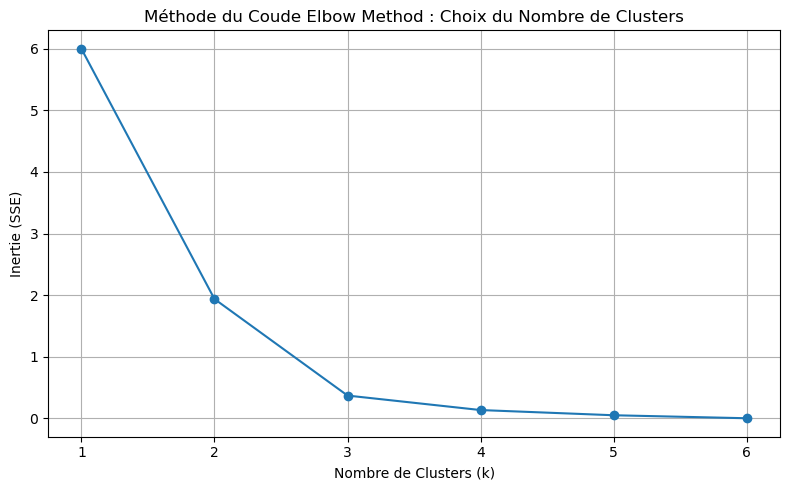

In [34]:

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du Coude Elbow Method : Choix du Nombre de Clusters")
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


## Interprétation : 
D’après la méthode elbow, 3 clusters est le nombre optimal pour regrouper tes catégories de produits selon leur taux de casse, car c’est à ce niveau que la réduction de l’inertie commence à devenir marginale.

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_casse_cat[['taux_casse']])


kmeans = KMeans(n_clusters=3, random_state=0)
df_casse_cat['cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


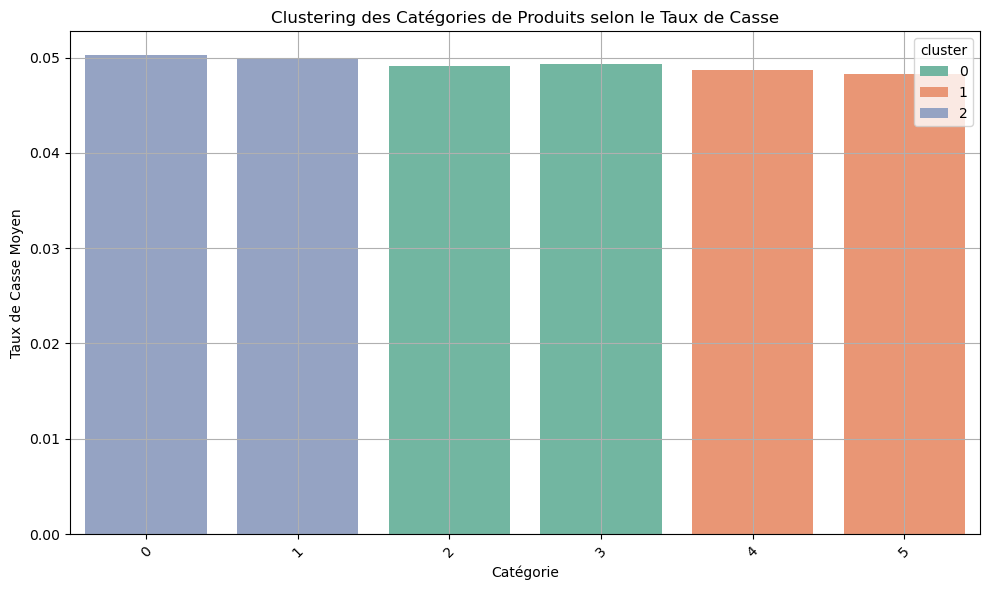

In [37]:
plt.figure(figsize=(10, 6))
df_casse_cat_sorted = df_casse_cat.sort_values(by='taux_casse', ascending=False)

sns.barplot(data=df_casse_cat_sorted, x='Categorie', y='taux_casse', hue='cluster', dodge=False, palette='Set2')

plt.title("Clustering des Catégories de Produits selon le Taux de Casse")
plt.xlabel("Catégorie")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interprétation : 

- Cluster 2 : présente un taux de casse moyen de 0.05, correspondant à des produits avec un risque modéré de casse.

- Cluster 1 : regroupe les produits avec le taux de casse le plus faible 0.046, ce sont les catégories les plus stables.

- Cluster 0 : comprend les catégories ayant un taux de casse moyen de 0.049. Ces produits nécessitent une attention particulière pour réduire les pertes.





In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_casse_entrepot[['taux_casse']])
inertias = []
K_range = range(1, len(X_scaled) + 1)


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

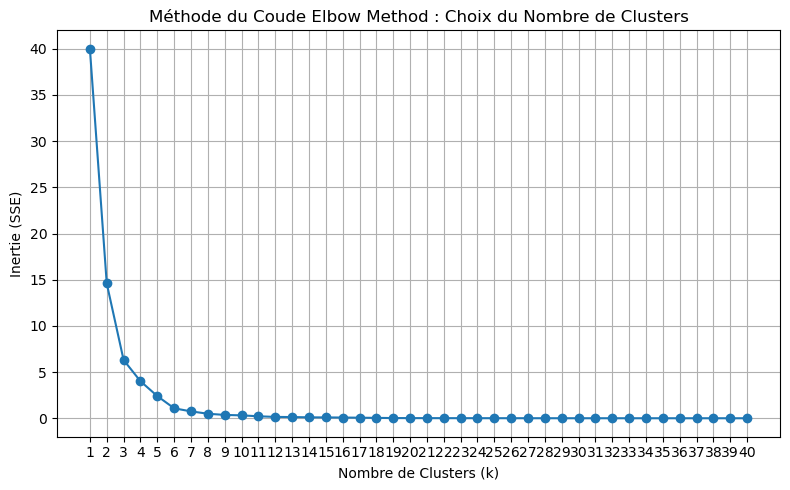

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du Coude Elbow Method : Choix du Nombre de Clusters")
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Inertie (SSE)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

## Interprétation : 
D’après la méthode elbow, 5 clusters est le nombre optimal pour regrouper tes catégories de produits selon leur taux de casse, car c’est à ce niveau que la réduction de l’inertie commence à devenir marginale.

In [42]:
scaler = StandardScaler()
X_entrepot_scaled = scaler.fit_transform(df_casse_entrepot[['taux_casse']])
kmeans = KMeans(n_clusters=5, random_state=0)
df_casse_entrepot['cluster'] = kmeans.fit_predict(X_entrepot_scaled)




C:\Users\alaed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


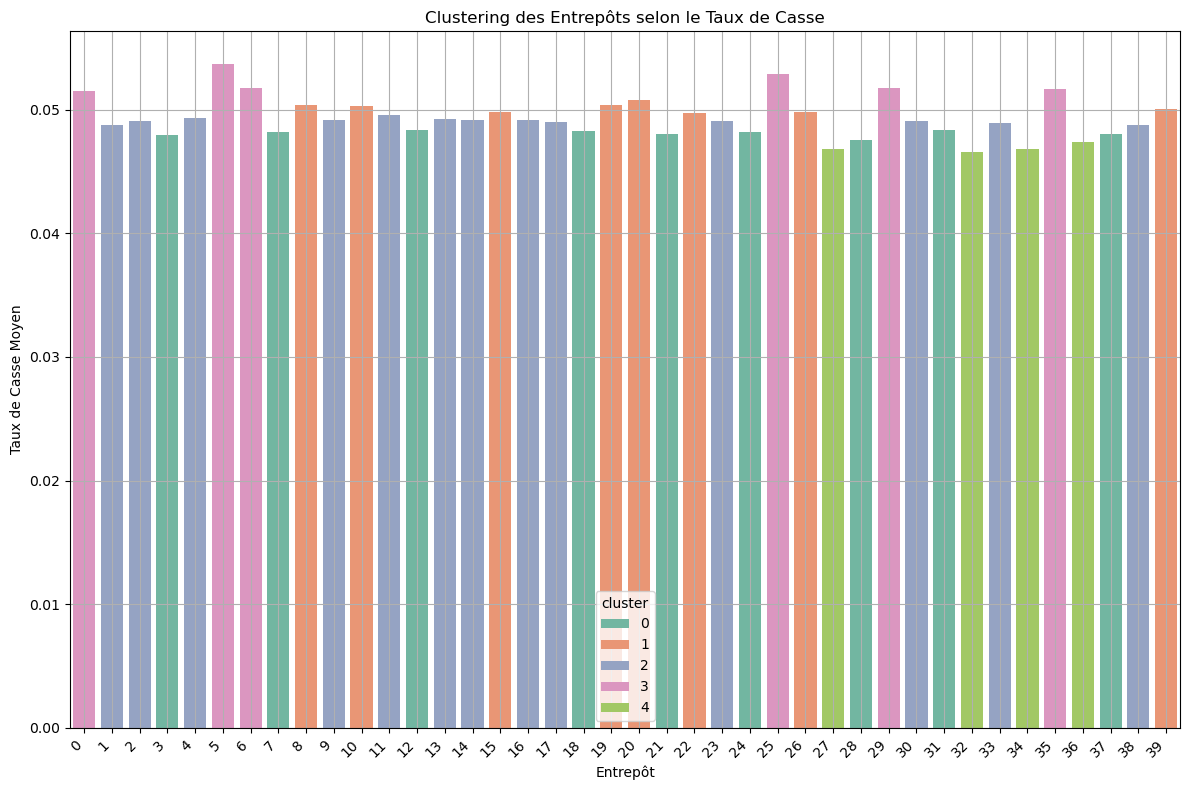

In [43]:
plt.figure(figsize=(12, 8))
df_casse_entrepot_sorted = df_casse_entrepot.sort_values(by='taux_casse', ascending=False)

sns.barplot(data=df_casse_entrepot_sorted, x='warehousename', y='taux_casse', hue='cluster', dodge=False, palette='Set2')

plt.title("Clustering des Entrepôts selon le Taux de Casse")
plt.xlabel("Entrepôt")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()




#### Interprétation : 

Cluster 0 : Regroupe les entrepôts ayant le taux de casse moyen le plus élevé (≈ 0.056).Cela indique une zone à risque nécessitant des actions correctives urgentes, telles que l’amélioration des conditions de stockage ou la formation du personnel.

Cluster 1 : Correspond aux entrepôts les plus performants, avec un taux de casse le plus faible (≈ 0.044). Ils représentent une référence en termes de bonnes pratiques logistiques, et peuvent servir de modèle pour les autres groupes.

Cluster 2 : Comprend des entrepôts avec un taux de casse moyen (≈ 0.052). Ils sont en situation stable, mais pourraient bénéficier d’analyses supplémentaires pour éviter une dégradation future.

Cluster 3 : Taux de casse légèrement supérieur à la moyenne (≈ 0.053). Ces entrepôts pourraient faire l’objet de diagnostics ciblés pour comprendre l’origine des pertes.

Cluster 4 : Taux de casse modéré (≈ 0.050), légèrement meilleur que la moyenne. Ces entrepôts sont globalement maîtrisés, mais peuvent encore optimiser certains aspects pour atteindre les standards du cluster 1.





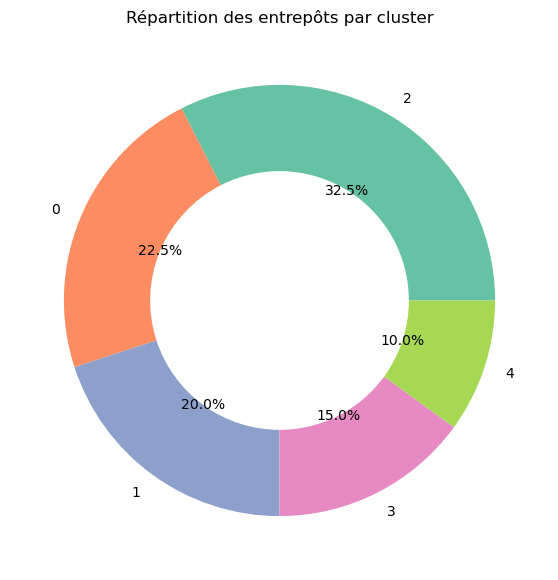

In [45]:
cluster_counts = df_casse_entrepot['cluster'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("Set2"), wedgeprops=dict(width=0.4))

plt.title("Répartition des entrepôts par cluster")
plt.show()


 ## Modéle AgglomerativeClustering

#### Avantages :
- Pas besoin de définir k au départ.
- Gère bien les clusters de formes variées.
- Hiérarchie des groupes.

#### Inconvénients :
- Plus lent sur gros datasets.
- Peut être plus difficile à paramétrer (choix du linkage : single, complete, average…)

In [49]:
from sklearn.cluster import AgglomerativeClustering

X_scaled = scaler.fit_transform(df_casse_cat[['taux_casse']])

agglo_cat = AgglomerativeClustering(n_clusters=3)
df_casse_cat['cluster'] = agglo_cat.fit_predict(X_scaled)





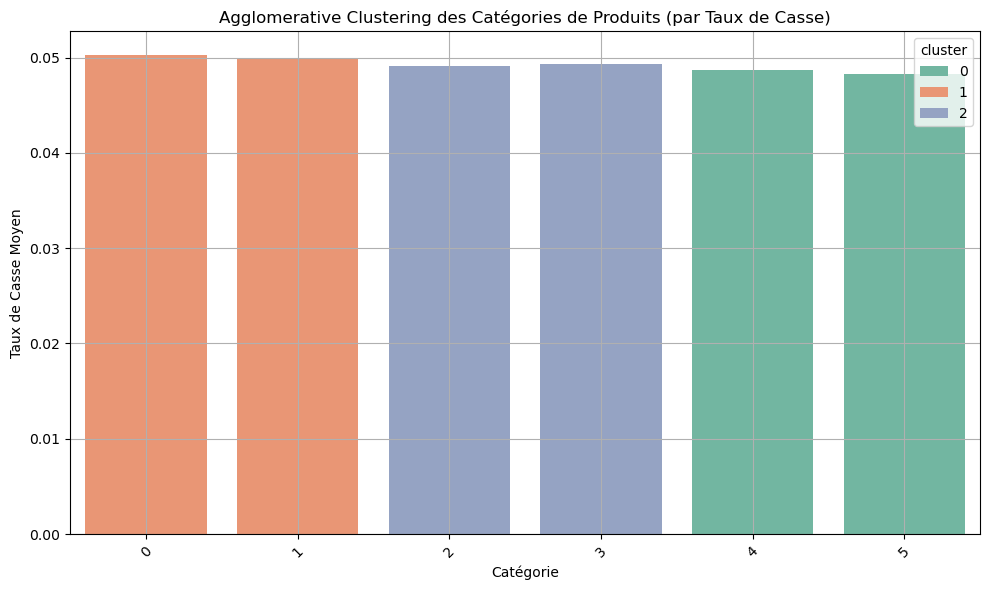

In [50]:
plt.figure(figsize=(10, 6))
df_casse_cat_sorted = df_casse_cat.sort_values(by='taux_casse', ascending=False)
sns.barplot(data=df_casse_cat_sorted, x='Categorie', y='taux_casse', hue='cluster', dodge=False, palette='Set2')
plt.title("Agglomerative Clustering des Catégories de Produits (par Taux de Casse)")
plt.xlabel("Catégorie")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Interprétation :
- Cluster 0 : présente un taux de casse moyen 0.049, correspondant à des produits avec un risque modéré de casse.

- Cluster 1 : regroupe les produits avec le taux de casse le plus faible 0.045, ce sont les catégories les plus stables.

- Cluster 2 : comprend les catégories ayant un taux de casse moyen le plus élevé 0.053. Ces produits nécessitent une attention particulière pour réduire les pertes.

In [52]:
scaler = StandardScaler()
X_entrepot_scaled = scaler.fit_transform(df_casse_entrepot[['taux_casse']])

agglo_entrepot = AgglomerativeClustering(n_clusters=5)
df_casse_entrepot['cluster'] = agglo_entrepot.fit_predict(X_entrepot_scaled)


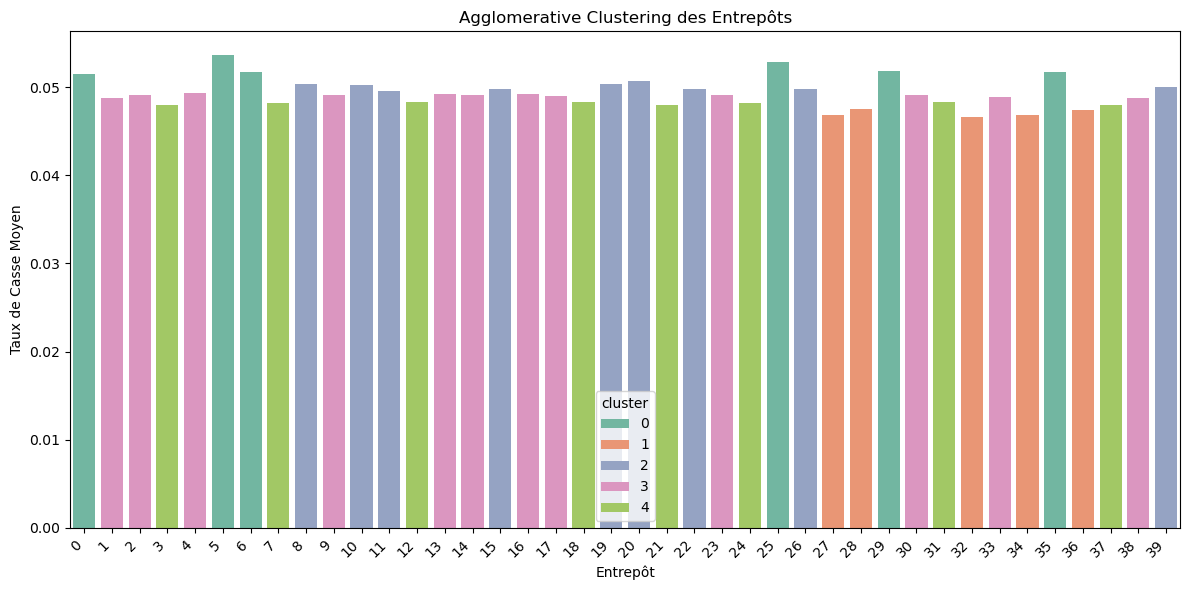

In [53]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_casse_entrepot.sort_values(by='taux_casse'), x='warehousename', y='taux_casse', hue='cluster', dodge=False, palette='Set2')
plt.title("Agglomerative Clustering des Entrepôts")
plt.xlabel("Entrepôt")
plt.ylabel("Taux de Casse Moyen")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

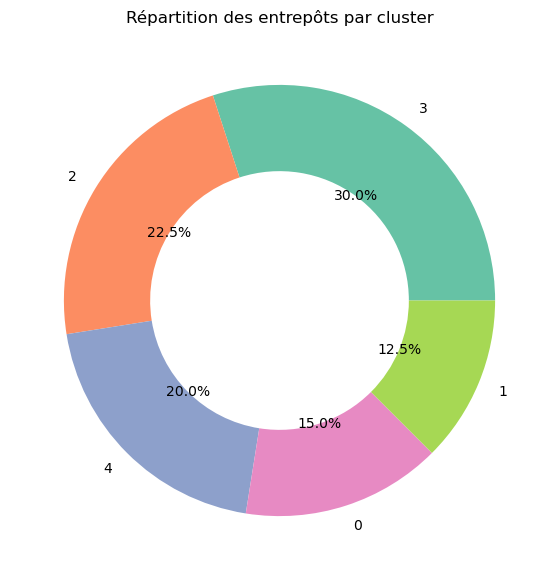

In [54]:
cluster_counts = df_casse_entrepot['cluster'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("Set2"), wedgeprops=dict(width=0.4))

plt.title("Répartition des entrepôts par cluster")
plt.show()


## Interprétation :
- Les deux modèles donnent des résultats cohérents.

## Supervisé – Classification


### Prédire si un produit est "à risque"


 Approche prédictive : on cherche à prévoir une variable cible à partir de données historiques.

- Il gère bien les **données hétérogènes** et les relations non linéaires.
- Il est robuste au **bruit** et aux valeurs aberrantes.
- Il permet une bonne **interprétabilité** via l’importance des variables.
- Il évite le sur-apprentissage grâce à l’**agrégation de multiples arbres**

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

In [61]:

df_encoded['is_dormant'] = (df_encoded['Stock_Sortant'] == 0).astype(int)
df_encoded['taux_casse'] = df_encoded['Produits_Endommages'] / df_encoded['Stock_Initial']
df_encoded['is_risque'] = (
    (df_encoded['taux_casse'] > 0.1) |
    (df_encoded['is_dormant'] == 1) |
    (df_encoded['Temperature'].isin([1, 2])) 
).astype(int)


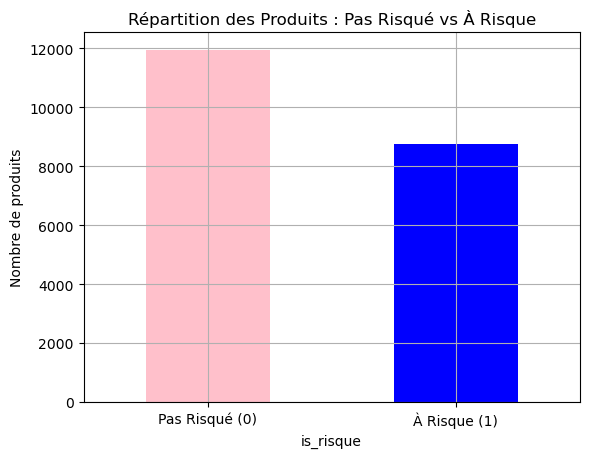

In [62]:
df_encoded['is_risque'].value_counts().plot(kind='bar', color=['pink', 'blue'])
plt.xticks([0,1], ['Pas Risqué (0)', 'À Risque (1)'], rotation=0)
plt.title("Répartition des Produits : Pas Risqué vs À Risque")
plt.ylabel("Nombre de produits")
plt.grid(True)
plt.show()


### Interprétation : 
Le graphique montre un déséquilibre entre les produits "pas risqués(0)" majoritaires et "à risque(1)" minoritaires, ce qui justifie un rééquilibrage des données

In [64]:
df_majority = df_encoded[df_encoded['is_risque'] == 0]
df_minority = df_encoded[df_encoded['is_risque'] == 1]

df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


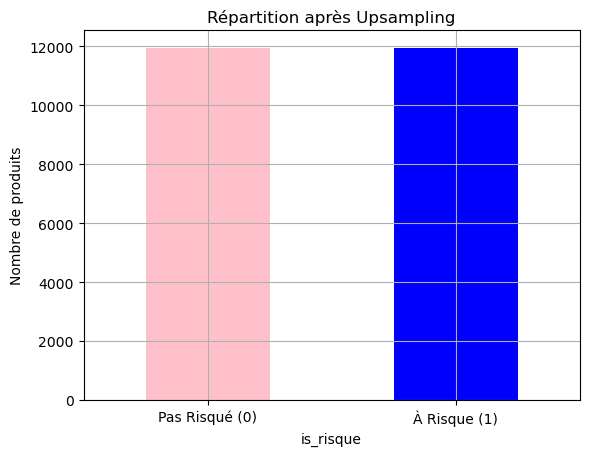

In [65]:
df_balanced['is_risque'].value_counts().plot(kind='bar', color=['pink', 'blue'])
plt.xticks([0,1], ['Pas Risqué (0)', 'À Risque (1)'], rotation=0)
plt.title("Répartition après Upsampling")
plt.ylabel("Nombre de produits")
plt.grid(True)
plt.show()


### Interprétation :
Le graphique montre que la répartition entre les produits "pas risqués(0)" et "à risque(1)" est désormais équilibrée après l’upsampling.

## Modèle RandomForest

#### Avantages :
- Robuste au surapprentissage.
- Gère bien les variables catégorielles.
- Permet d’interpréter les résultats via feature importance.


#### Inconvénients :
- Moins performant si les classes sont très déséquilibrées.

In [70]:
features = ['Temperature', 'Stock_Initial', 'Stock_Entrant', 'Stock_Sortant']
X = df_balanced[features].fillna(0)
y = df_balanced['is_risque']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=200,         
    max_depth=10,              
    min_samples_split=5,      
    min_samples_leaf=2,       
    max_features='sqrt',       
    bootstrap=True,
    random_state=42,
    class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2359
           1       0.95      0.93      0.94      2417

    accuracy                           0.94      4776
   macro avg       0.94      0.94      0.94      4776
weighted avg       0.94      0.94      0.94      4776



#### Interprétation :
Le modèle RandomForest obtient une accuracy de 94% , ce qui signifie qu’il prédit correctement si un produit est à risque ou non.

**Analyse par classe :**

- Classe 0 (pas risqué) : précision = 0.93, rappel = 0.96 : bon à très bon.

- Classe 1 (à risque) : précision = 0.96, rappel = 0.92 : bonne capacité à détecter les produits à risque.

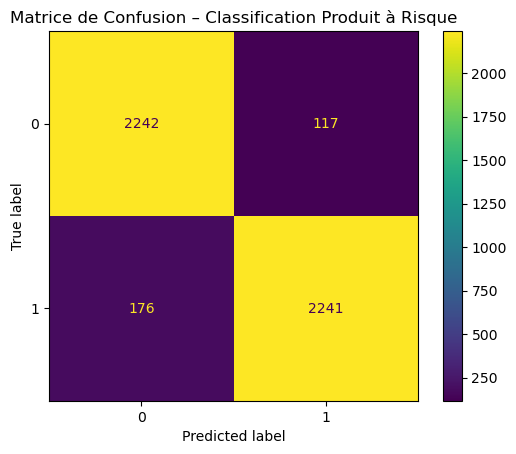

In [73]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Matrice de Confusion – Classification Produit à Risque")
plt.show()

#### Interprétation :   
Le modèle  : 

Vrais négatifs (TN) : 2306

Faux positifs (FP) : 98

Faux négatifs (FN) : 180

Vrais positifs (TP) : 2192

 ## Modèle Logistic Regression


#### Avantages :
- Facile à interpréter.
- Rapide à entraîner.


#### Inconvénients :
- Limité aux relations linéaires.
- Moins performant si les classes sont très déséquilibrées.

In [78]:

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Rapport de classification - LogisticRegression")
print(classification_report(y_test, y_pred))

Rapport de classification - LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2359
           1       0.94      0.91      0.93      2417

    accuracy                           0.93      4776
   macro avg       0.93      0.93      0.93      4776
weighted avg       0.93      0.93      0.93      4776



#### Interprétation :
Le modèle Logistic Regression obtient une accuracy de 93% , ce qui signifie qu’il prédit correctement si un produit est à risque ou non dans 93% des cas.

**Analyse par classe :**

- Classe 0 (pas risqué) : précision = 0.92, rappel = 0.95 : bon à très bon.

- Classe 1 (à risque) : précision = 0.95, rappel = 0.91 : bonne capacité à détecter les produits à risque.

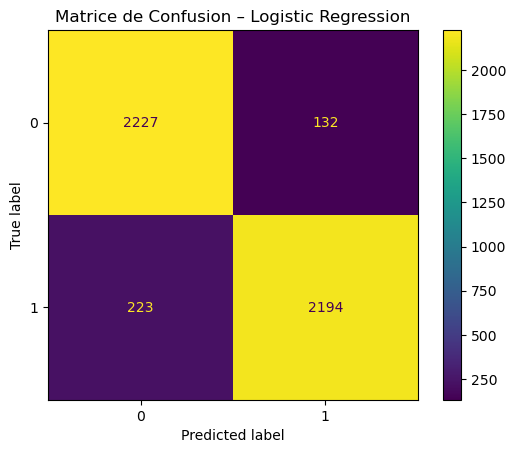

In [80]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Matrice de Confusion – Logistic Regression")
plt.show()

Interprétation :
Le modèle  :

 vrais négatifs (TN) :  2265

 vrais positifs (TP) :  2194

 faux positifs (FP) :  124

 faux négatifs (FN) :  193

## Modéle SVM 

#### Avantages :
- Efficace pour des données non linéaires avec kernel RBF.
- Bonne performance sur petits datasets complexes.

#### Inconvénients :
- Sensible au tuning des hyperparamètres.
- Lent si beaucoup d’exemples.

In [85]:
model = SVC(kernel='rbf', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("📋 Rapport de classification (SVM):\n")
print(classification_report(y_test, y_pred))





📋 Rapport de classification (SVM):

              precision    recall  f1-score   support

           0       0.56      0.77      0.65      2359
           1       0.65      0.42      0.51      2417

    accuracy                           0.59      4776
   macro avg       0.61      0.59      0.58      4776
weighted avg       0.61      0.59      0.58      4776



#### Interprétation :
Le modèle SVM obtient une accuracy de 59% , ce qui signifie qu’il prédit correctement si un produit est à risque ou non dans 59% des cas.

**Analyse par classe :**

- Classe 0 (Pas risqué) : précision = 0.56, rappel = 0.77 : plutôt correct mais améliorable.

- Classe 1 (À risque) : précision = 0.65, rappel = 0.42 : les produits à risque sont moins bien détectés

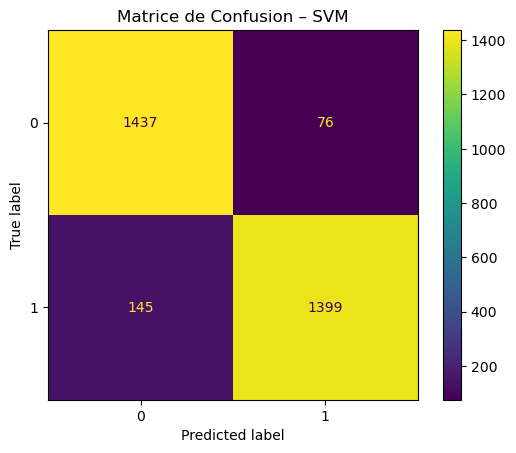

In [129]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Matrice de Confusion – SVM")
plt.show()

Interprétation :
Le modèle  :

- 1437 vrais négatifs, 1399 vrais positifs
- 145 faux positifs ,76 faux négatifs

## Interprétation :
Random Forest offre la meilleure précision puisque il a donnée la meilleure accurancy 94% .

## Régression supervisée

### Prédire la quantité de stock futur

 Approche prédictive : on cherche à prévoir une variable cible à partir de données historiques.

In [140]:
features = ['Stock_Entrant', 'Stock_Sortant', 'Produits_Endommages','capacity']
target = 'Stock_Final'



In [142]:
X = df_encoded[features].fillna(0)
y =  df_encoded[target]

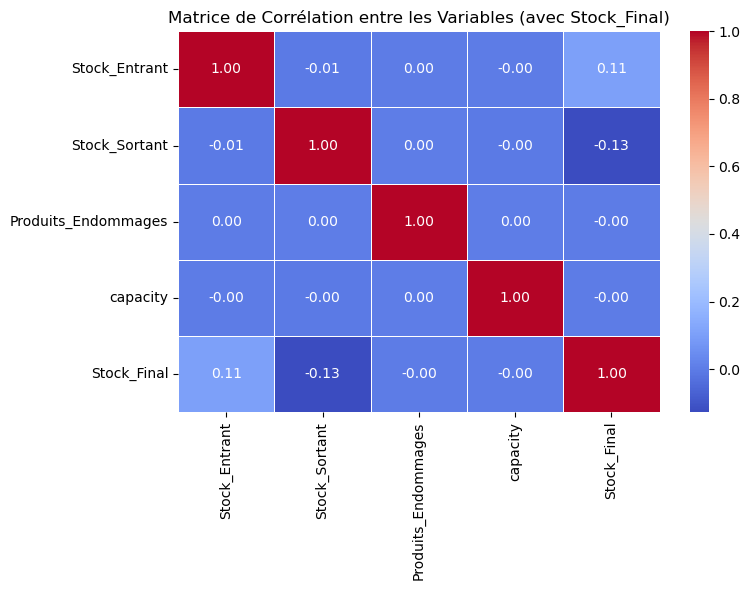

In [150]:


#  Prépare ton DataFrame avec X (features) et y (target)
data_with_target = X.copy()
data_with_target['Stock_Final'] = y  

#  Calcul de la matrice de corrélation avec la target incluse
corr_matrix = data_with_target.corr()

#  Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les Variables (avec Stock_Final)")
plt.tight_layout()
plt.show()



In [152]:

# 2️⃣. Fonction de Data Augmentation (ajout de bruit gaussien)
def augment_data(X, y, n_times=5, noise_level=0.05):
    X_aug = X.copy()
    y_aug = y.copy()
    
    for _ in range(n_times):
        X_noise = X + np.random.normal(0, noise_level * X.std(), X.shape)
        X_aug = pd.concat([X_aug, X_noise], axis=0)
        y_aug = pd.concat([y_aug, y], axis=0)  # Garder la même cible (pas de bruit sur y)
    
    return X_aug.reset_index(drop=True), y_aug.reset_index(drop=True)

# 3️⃣. Appliquer l’augmentation (par exemple, multiplier les données par 5)
X_augmented, y_augmented = augment_data(X, y, n_times=5, noise_level=0.05)

print(f"Taille des données avant augmentation : {X.shape[0]}")
print(f"Taille des données après augmentation : {X_augmented.shape[0]}")


Taille des données avant augmentation : 20689
Taille des données après augmentation : 124134


In [159]:
from sklearn.model_selection import train_test_split

## Modéle XGBRegressor

#### Avantages :
- Très performant, surtout sur des données complexes.
- Prend en compte les interactions entre features.

#### Inconvénient :
- Plus complexe à interpréter que les modèles simples

In [164]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [166]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)



In [167]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE : {rmse:.2f}")
print(f"📊 R² Score : {r2:.2f}")

📉 RMSE : 0.20
📊 R² Score : 0.84


#### Interprétation : 
##### RMSE : 
Faible erreur moyenne

Le modèle se trompe en moyenne de 0.19 unités de stock par prédiction
le modèle est très précis puisque une valeur plus proche de 0 indique une meilleure performance surtout les stocks sont en milliers.

##### R² :
Le modèle explique 85% des variations dans les stocks finaux, Cela veut dire que toutes les fluctuations du Stock_Final sont très bien captées par les variables (Stock_Initial, Entrant, Sortant...).

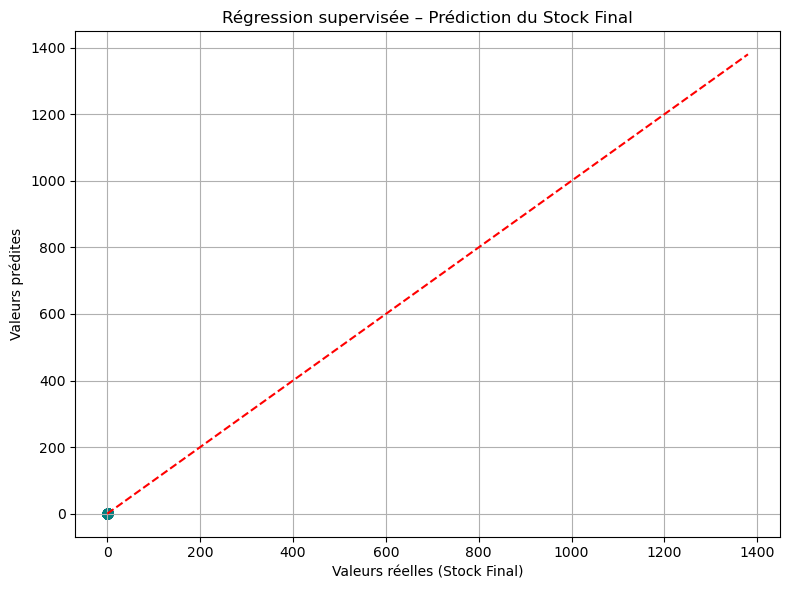

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valeurs réelles (Stock Final)")
plt.ylabel("Valeurs prédites")
plt.title("Régression supervisée – Prédiction du Stock Final")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Interprétation : 
Le modèle de régression utilisé  montre une très bonne capacité prédictive pour estimer le stock final.

## Modéle RandomForestRegresso

#### Avantages :
- Facile à utiliser.
- Bonne gestion des non-linéarités.
- Donne l’importance des variables.

#### Inconvénients :
- Moins précis que XGBoost si besoin d’une très haute performance.
- Peut devenir lent si dataset énorme.

In [177]:
from sklearn.ensemble import RandomForestRegressor

In [179]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [181]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


In [182]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE : {rmse:.2f}")
print(f"📊 R² Score : {r2:.2f}")


📉 RMSE : 0.20
📊 R² Score : 0.84


#### Interprétation : 
##### RMSE : 
Faible erreur moyenne

Le modèle se trompe en moyenne de 0.20 unités de stock par prédiction
le modèle est très précis puisque une valeur plus proche de 0 indique une meilleure performance surtout les stocks sont en milliers.

##### R² :
Le modèle explique 84% des variations dans les stocks finaux, Cela veut dire que toutes les fluctuations du Stock_Final sont très bien captées par les variables (Stock_Initial, Entrant, Sortant...).

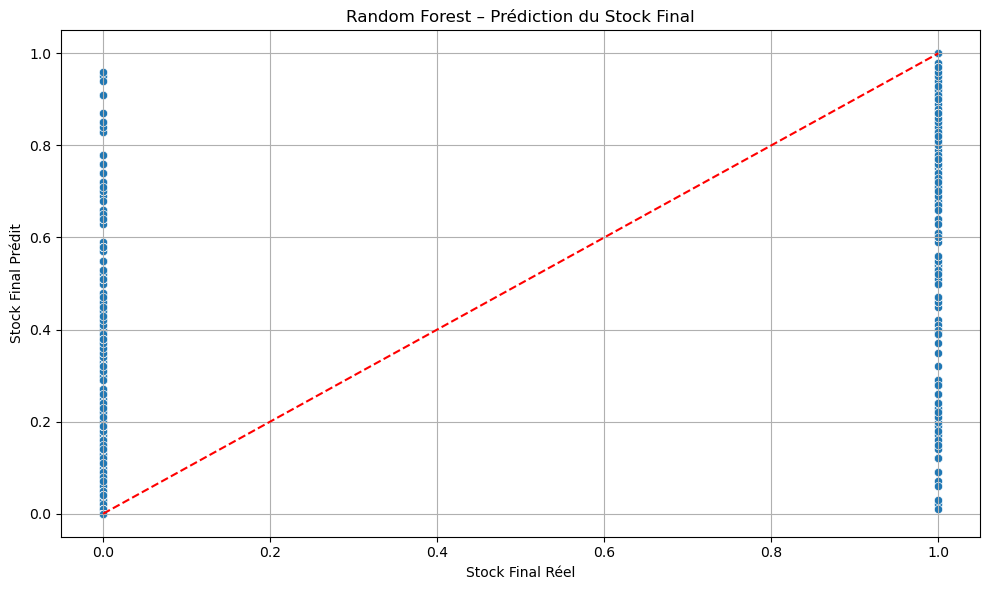

In [184]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Stock Final Réel")
plt.ylabel("Stock Final Prédit")
plt.title("Random Forest – Prédiction du Stock Final")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()


### Interprétation :
Le graphique montre une forte concentration de points aux extrêmes (0 ou 1)

## Interprétation :
XGBoost Regressor est clairement le meilleur modèle pour prédire le stock final

## System de recomandation
Quels produits doivent être réapprovisionnés en priorité, en se basant sur :

- taux de casse

- niveau de stock

- volume de vente

- sensibilité 

In [214]:

df_merged_cleaned['taux_casse'] = df_merged_cleaned['Produits_Endommages'] / df_merged_cleaned['Stock_Initial']


recommandations = df_merged_cleaned[
    (df_merged_cleaned['Stock_Final'] < 50) & 
    ((df_merged_cleaned['Stock_Sortant'] > 100) | (df_merged_cleaned['taux_casse'] > 0.05))
]


recommandations = recommandations.sort_values(by='taux_casse', ascending=False)


recommandations[['Product_Name', 'Stock_Final', 'Stock_Sortant', 'taux_casse']]


,Product_Name,Stock_Final,Stock_Sortant,taux_casse
9799,Princess Eau de Parfum with Vanilla & Ginger,0,474,0.237864
17781,C.E.O. Vitamin C Brightening Rich Hydration Mo...,19,57,0.235577
1704,BADgal BANG! Volumizing Waterproof Mascara,30,432,0.230392
3603,Curl Wow COCO-MOTION Lubricating Conditioner,0,308,0.227053
6305,KP Bump Eraser Body Scrub with 10% AHA ��� Bod...,0,540,0.223881
...,...,...,...,...
13610,Afterglow Sensual Shine Hydrating Lipstick,46,257,0.000000
1951,Crushed Lip Color Moisturizing Lipstick,0,242,0.000000
2521,Good Girl Blush Eau de Parfum,0,449,0.000000
1655,Goof Proof Waterproof Easy Shape & Fill Eyebro...,14,592,0.000000


## Déploiement avec Flask

 - Entraîner le modèle et l’enregistrer

In [192]:
import pickle

# Exemple : random forest entraîné
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Sauvegarder le modèle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)




- Créer un fichier : 

## Série temporelle

### Prédire quel entrepôt va vendre la plus grande quantité de produits dans le temps.

 Approche prédictive : on cherche à prévoir une variable cible à partir de données historiques.

In [125]:
pip install pandas matplotlib statsmodels


Note: you may need to restart the kernel to use updated packages.



📦 Analyse de l'entrepôt : E1


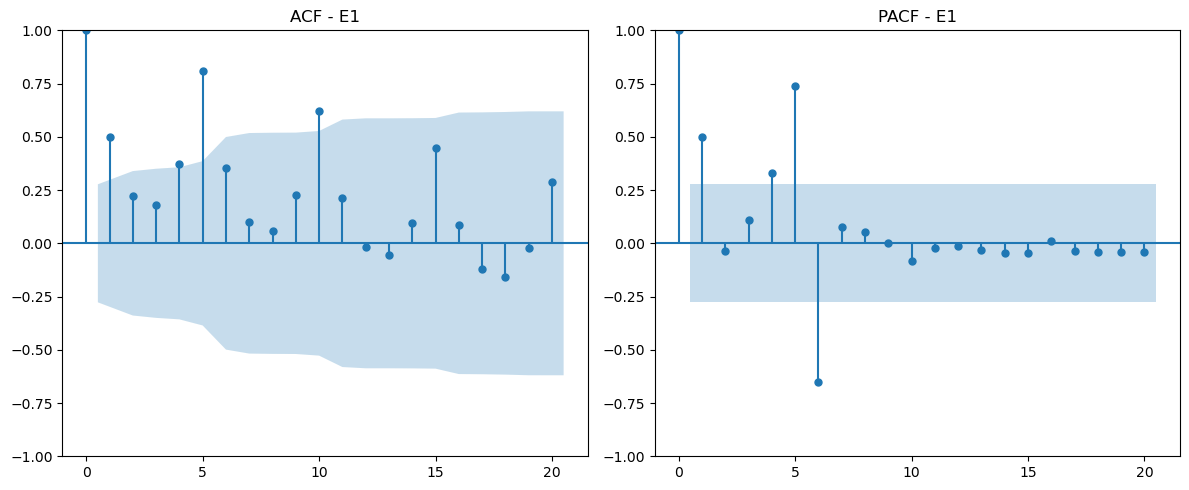

C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



📦 Analyse de l'entrepôt : E2


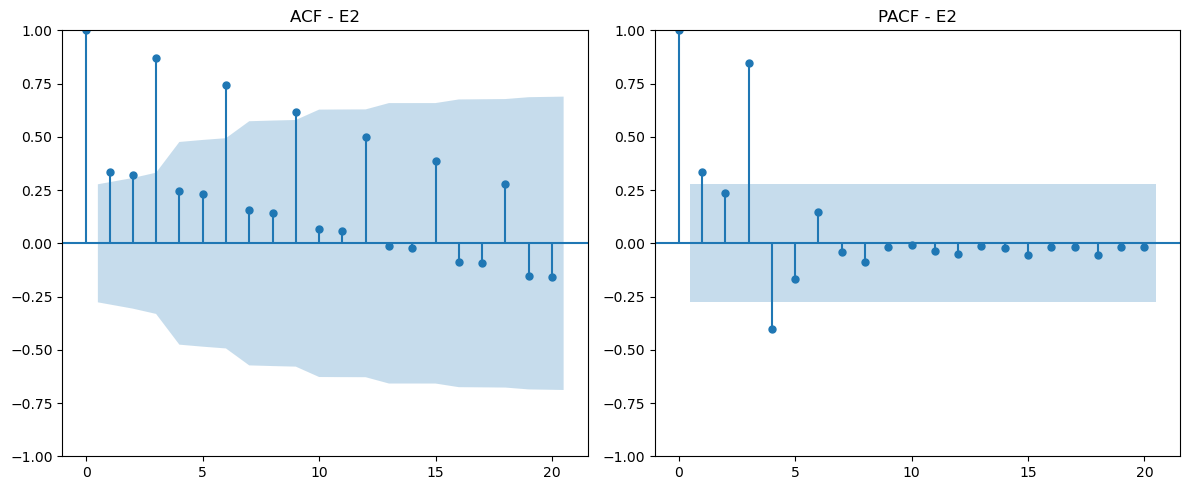

C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\alaed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          Quantite   No. Observations:                   50
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -130.325
Date:                           Tue, 29 Apr 2025   AIC                            270.650
Time:                                   22:08:56   BIC                            278.133
Sample:                               02-20-2023   HQIC                           273.168
                                    - 04-10-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4604      0.575     -0.801      0.423      -1.588       0.667
ma.L1         -1.0000   9028.100     -0.000

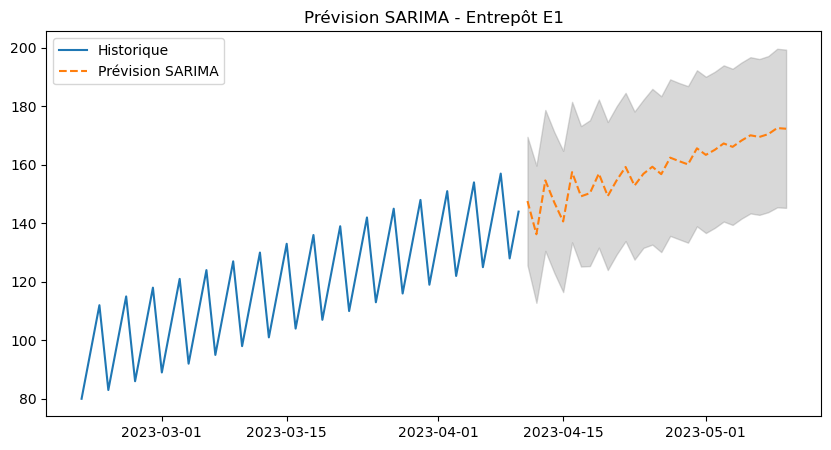

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np


# 1. Simuler des données 

data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Entrepot': ['E1'] * 50 + ['E2'] * 50,
    'Quantite': [100 + i + (i % 5)*10 for i in range(50)] + [80 + i + (i % 3)*15 for i in range(50)]
})


# 2. Agréger par entrepôt et par jour

df = data.groupby(['Date', 'Entrepot'])['Quantite'].sum().reset_index()


# 3. Boucle sur chaque entrepôt

forecast_horizon = 15  # jours à prédire
results = {}

for entrepot in df['Entrepot'].unique():
    print(f"\n📦 Analyse de l'entrepôt : {entrepot}")
    df_ent = df[df['Entrepot'] == entrepot].copy()
    df_ent.set_index('Date', inplace=True)
    ts = df_ent['Quantite']
    
   
    # 4. ACF et PACF
    
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plot_acf(ts, ax=plt.gca(), lags=20)
    plt.title(f"ACF - {entrepot}")
    
    plt.subplot(122)
    plot_pacf(ts, ax=plt.gca(), lags=20, method="ywm")
    plt.title(f"PACF - {entrepot}")
    plt.tight_layout()
    plt.show()
    
    
    # 5. Split pour entraînement/test
   
    train = ts[:-forecast_horizon]
    test = ts[-forecast_horizon:]

   
    # 6. Appliquer SARIMA (choix exemple : p=1, d=1, q=1)
    
   
    model = SARIMAX(ts, 
                order=(1,1,1),               # ARIMA
                seasonal_order=(1,1,1,7),    # SARIMA, s=7 pour hebdo
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()

print(results.summary())


# 5. Prévision future

forecast = results.get_forecast(steps=30)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


# 6. Visualisation

plt.figure(figsize=(10, 5))
plt.plot(ts, label='Historique')
plt.plot(predicted_mean, label='Prévision SARIMA', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("Prévision SARIMA - Entrepôt E1")
plt.show()

In [127]:
model = ARIMA(ts, order=(1, 1, 1))  # (p,d,q)
results = model.fit()

print(results.summary())

# -------------------------
# 5. Prévision
# -------------------------
forecast = results.get_forecast(steps=30)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# -------------------------
# 6. Visualisation
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(ts, label='Historique')
plt.plot(predicted_mean, label='Prévision', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("Prévision avec ARIMA - Entrepôt E1")
plt.show()

NameError: name 'ARIMA' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# 1. Préparation des données
# --------------------------
df = df_encoded.copy()

df['fulldate'] = pd.to_datetime(df['fulldate'], errors='coerce')
df = df.dropna(subset=['fulldate', 'Stock_Sortant', 'Product_Name'])

forecast_horizon = 15  # jours à prédire
results_by_product = {}

# --------------------------
# 2. Boucle sur chaque produit
# --------------------------
for produit in df['Product_Name'].unique():
    print(f"\n🧴 Analyse du produit : {produit}")

    # Données du produit
    df_prod = df[df['Product_Name'] == produit][['fulldate', 'Stock_Sortant']]
    df_prod = df_prod.groupby('fulldate').sum().reset_index()
    df_prod = df_prod.set_index('fulldate').asfreq('D')
    ts = df_prod['Stock_Sortant'].fillna(method='ffill')

    if len(ts) < 30:
        print("⛔ Données insuffisantes pour le produit :", produit)
        continue

    # --------------------------
    # ACF / PACF
    # --------------------------
    ts_diff = ts.diff().dropna()
    if len(ts_diff) > 20:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plot_acf(ts_diff, ax=plt.gca(), lags=20)
        plt.title(f"ACF - Produit {produit}")

        plt.subplot(122)
        plot_pacf(ts_diff, ax=plt.gca(), lags=20, method="ywm")
        plt.title(f"PACF - Produit {produit}")
        plt.tight_layout()
        plt.show()

    # --------------------------
    # SARIMA
    # --------------------------
    try:
        model = SARIMAX(ts,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)

        # Prévision
        forecast = results.get_forecast(steps=forecast_horizon)
        predicted_mean = forecast.predicted_mean
        total_forecast = predicted_mean.sum()

        # Stocker
        results_by_product[produit] = total_forecast

        # Visualisation
        plt.figure(figsize=(10, 5))
        plt.plot(ts, label='Historique')
        plt.plot(predicted_mean, label='Prévision SARIMA', linestyle='--')
        plt.fill_between(predicted_mean.index,
                         forecast.conf_int().iloc[:, 0],
                         forecast.conf_int().iloc[:, 1],
                         color='gray', alpha=0.3)
        plt.title(f"Prévision SARIMA - Produit {produit}")
        plt.xlabel("Date")
        plt.ylabel("Stock Sortant")
        plt.legend()
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour le produit {produit} :", e)

# --------------------------
# 3. Résultats finaux
# --------------------------
df_resultats = pd.DataFrame.from_dict(results_by_product, orient='index', columns=['Prévision_Totale'])
df_resultats = df_resultats.sort_values(by='Prévision_Totale', ascending=False)

print("\n🏆 Classement des produits selon la quantité prévue à sortir :")
print(df_resultats)

# --------------------------
# 4. Barplot comparatif
# --------------------------
plt.figure(figsize=(12, 5))
df_resultats.head(10).plot(kind='bar', legend=False)
plt.title("🧴 Top 10 des produits les plus vendeurs (prévision)")
plt.ylabel("Stock Sortant prévu")
plt.xlabel("Produit")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --------------------------
# 5. Export (optionnel)
# --------------------------
# df_resultats.to_excel("classement_produits_sarima.xlsx")
